# Putting everything togehter

In this notebook we put everything together to create the segmentations masks from both models as well as using these masks to get further insight.  

## Clustering

We wanted to look at "clusters" of deforestation events in our binary mask (the mask that contains all zeros for every pixels that's part of a deforestation event) to look at the size of each deforestation event and gain insight into their distribution and composition. The following code snippets were used to test our approach for the clustering.

In [101]:
!pip install --q scikit-image

In [2]:
import torch
from skimage.measure import label

matrix = torch.tensor([
    [1, 0, 0, 1],
    [0, 0, 1, 1],
    [1, 1, 0, 0],
    [0, 0, 0, 1]
], dtype=torch.int)

In [3]:
matrix = 1 - matrix

In [4]:
lmatrix, nc = label(matrix.numpy(), connectivity=2, return_num=True)

c_sizes = torch.bincount(torch.tensor(lmatrix.flatten()))
c_sizes = c_sizes[1:]  # Exclude background label (0)
nc = len(c_sizes)
nc, c_sizes

(1, tensor([9]))

## Loading the model

After that, we loaded the binary segmentation model to write some convenience functions to quickly get a prediction from a filename as well as displaying the masks.

In [102]:
from fastai.vision.all import *

In [6]:
models_path = Path.cwd() / "models"

In [7]:
def label_func(path):
    fname = path.name
    img_id = str(fname.split("_sat")[0])
    return path.parent / (img_id + "_mask_pre_binary.png")

In [8]:
binary_unet = load_learner(models_path / "binary_unet_convnext_focal_256px_10e_bs8_gac_aug.pkl")

## Creating a function to easily get the predictions for a file

In [9]:
from dataclasses import dataclass

@dataclass
class BinarySegmentationPrediction:
    mask: torch.Tensor
    probabilities: torch.Tensor


def binary_segmentation(path):
    _, pred, pred_proba = binary_unet.predict(path)
    return BinarySegmentationPrediction(
        pred,
        pred_proba[1]
    )

In [103]:
prediction = binary_segmentation(
    Path.cwd() / "segmentation_preprocessed" / "test" / "287212_sat.jpg"
)

/Users/smorrin/anaconda3/lib/python3.11/site-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/Users/smorrin/anaconda3/lib/python3.11/site-packages/fastai/metrics.py:390: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


## Showing the prediction

In [104]:
from torchvision.transforms.functional import to_pil_image

def show_prediction(prediction: BinarySegmentationPrediction):
    return to_pil_image(prediction.mask.float())

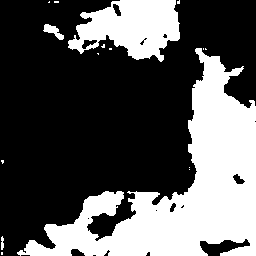

In [95]:
show_prediction(prediction)

## Doing the clustering

This part contains the cluster analysis on the predicted mask. Since the mask contains zeros for deforestation events but our approach requires them to be ones, we have to invert the matrix first.

In [105]:
pred_matrix = 1 - prediction.mask
pred_matrix

TensorBase([[1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            ...,
            [1, 0, 0,  ..., 0, 0, 0],
            [1, 0, 0,  ..., 0, 0, 0],
            [1, 1, 1,  ..., 0, 0, 0]])

In [106]:
lmatrix, nc = label(pred_matrix.numpy(), connectivity=2, return_num=True)

c_sizes = torch.bincount(torch.tensor(lmatrix.flatten()))
c_sizes = c_sizes[1:]
nc = len(c_sizes)
nc, c_sizes

(17,
 tensor([42087,    59,    12,    15,    73,     1,    67,    34,     5,     1,
             1,   447,    72,    15,    12,     9,     3]))

Now that we have all clusters and their respective sizes, we'll look at:
- how much of the image is part of a deforestation event
- how big is the average cluster (mean & median)
- what is the standard deviation of the clusters - are there any clusters that are particularily bigger than others?

In [112]:
c_sizes.sum() / (256 * 256)

tensor(0.6548)

In [113]:
c_sizes.float().mean()

tensor(2524.2942)

In [114]:
c_sizes.float().median()

tensor(15.)

In [115]:
c_sizes.float().std()

tensor(10195.6201)

## Loading the convnext unet

After taking a look at the binary segmentation data, we loaded our multiclass unet segmentation model to determinte the exact type of deforestation event. As with the binary segmentation model, we wrote some convenience functions for that.

In [75]:
unet = load_learner(models_path / "convnext_large_256px_8bs_68ds.pkl")

In [59]:
classes = [
    "urban_land",
    "agriculture_land",
    "rangeland",
    "forest_land",
    "water",
    "barren_land",
    "unknown"
]

In [76]:
@dataclass
class MultiSegmentationPrediction:
    mask: torch.Tensor

def get_multisegmentation_prediction(path):
    _, preds, _ = unet.predict(path)
    return MultiSegmentationPrediction(preds)

In [116]:
multi_prediction = get_multisegmentation_prediction(Path.cwd() / "segmentation_preprocessed" / "test" / "287212_sat.jpg")

In [90]:
def show_multisegmentation_prediction(prediction):
    # Since there are 6 different classes, we have to divide by 6 here
    return to_pil_image(prediction.mask.float() / 6)

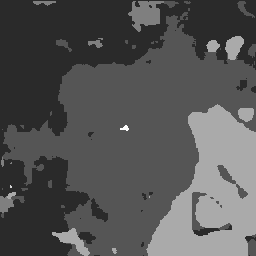

In [117]:
show_multisegmentation_prediction(multi_prediction)

## CO2 Evaluation

Now that we have both models setup, we want to gain some insight.

The first thing we did was to check how the deforestation events impact the CO2 emissions. 

We did this by calculating the area that the deforestation event covers and multiplying that area by an estimate of carbon emissions per hectar (which was taken from the scientific advisors of the Bundestag).

One pixel in the image corresponds to 50cm in real life, which means that one image's area is 1,498176km2 since an image has a size if 2448x2448px.

Per hectar, a forest can store ~385t of CO2 equivalent (source: "Umgerechnet auf Waldflächen entspricht diese Angabe rund 385 t CO2-Äq je ha Wald" from https://www.bundestag.de/resource/blob/673914/74cf34356739f35d07ba3a0de67fca0d/WD-8-077-19-pdf-data.pdf)

In [99]:
def get_co2_impact(prediction):
    pred_matrix = 1 - prediction.mask
    non_forest_part = pred_matrix.flatten().float().mean()
    lost_forest_km2 = non_forest_part * 1.498176
    return int(100 * lost_forest_km2 * 385)

In [100]:
get_co2_impact(prediction)

37768

Now we have calculated the estimated CO2 impact of this deforestation event (in tons).

Using our multiclass segmentation mask we can gain even more insight into the environmental impact.

We divide the deforestation events into multiple classes based on their land use and deduct a very rough estimate of potential emissions from that. 

The emission classes are high emissions, medium emissions and low emissions.

Source for our estimate: https://de.statista.com/statistik/daten/studie/1241046/umfrage/treibhausgasemissionen-in-deutschland-nach-sektor/

| High emissions | Medium Emissions  | Low emissions |
|----------------|-------------------|---------------|
| Rangeland      | Agricultural land | Unknown       |
| Urban land     |                   | Barren land   |

In [120]:
# Values in the mask
high_vals = [2, 0]
medium_vals = [1]
low_vals = [5, 6]

In [172]:
def get_emissions_per_event(multi_pred, pred_binary):
    pred_mask = multi_pred.mask
    size = pred_mask.shape[0]
    high_cnt = 0
    med_cnt = 0
    low_cnt = 0
    # Somewhat inefficient, but no time :(
    for i in range(size):
        for j in range(size):
            if pred_binary.mask[i][j] == 1: continue
            if pred_mask[i][j] in high_vals: high_cnt += 1
            elif pred_mask[i][j] in medium_vals: med_cnt += 1
            elif pred_mask[i][j] in low_vals: low_cnt += 1
    cnt_deforestation_events = (1 - pred_binary.mask).sum().float()
    # Since our other model may have missed some deforestation events, we'll classify those as unknown
    if (high_cnt + med_cnt + low_cnt) < cnt_deforestation_events:
        low_cnt += cnt_deforestation_events - (high_cnt + med_cnt + low_cnt)
    return (
        high_cnt / cnt_deforestation_events,
        med_cnt / cnt_deforestation_events,
        low_cnt / cnt_deforestation_events
    )

In [173]:
import matplotlib.pyplot as plt
def show_emissions_per_event(multi_pred, binary_pred):
    high, med, low = get_emissions_per_event(multi_pred, binary_pred)
    plt.xlabel("Deforestation events composition (%)")
    plt.ylabel("Emission type") 
    plt.barh(
        [
            "High",
            "Medium",
            "Low"
        ], [
            high * 100.0, med * 100.0, low * 100.0
        ]
    )

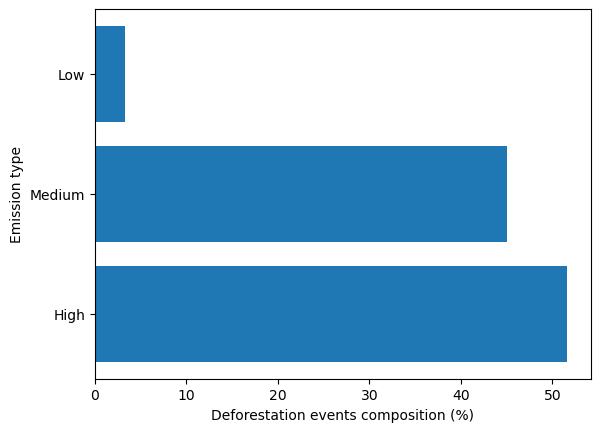

In [174]:
show_emissions_per_event(multi_prediction, prediction)

Now we can see that a ~50% of our deforestation events with potentially high impact.  